# Chapter 12: Discriminant Analysis and Other Linear Classification Models

In [1]:
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

<Figure size 640x480 with 0 Axes>

## 1. Read Data

In [2]:
# year 2008 has 2075 records, pre 2008 has 6633 records
# Training : pre2008 data + 1557 records in year 2008
# Testing: 518 records in year 2008
training = pd.read_csv('./grantdata_training.csv')
testing = pd.read_csv('./grantdata_testing.csv')
year2008Data = pd.read_csv('./grantdata_year2008Data.csv')

print(training.info())
print(testing.info())
print(year2008Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 118.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 7.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 30.0+ MB
None


In [3]:
fullSet = pd.read_csv("./fullset.csv")['colName'].to_list()
reducedSet = pd.read_csv("./reducedset.csv")['colName'].to_list()

len(fullSet), len(reducedSet) #1069,  255 changed Day to yDay

(1069, 255)

In [4]:
trainData = training[~training.index.isin(year2008Data.index)]
validData = training[training.index.isin(year2008Data.index)]
fillNAcols = ['CI.PhD','DR.PhD','ECI.PhD','HV.PhD','PS.PhD','SR.PhD','EA.PhD','SCI.PhD','UNK.PhD']
trainData[fillNAcols] = trainData[fillNAcols].fillna(0)
validData[fillNAcols] = validData[fillNAcols].fillna(0)

trainData['yDay2'] = trainData['yDay']**2
validData['yDay2'] = validData['yDay']**2

In [5]:
trainX0 = trainData.drop(columns = ['Class'])
trainy = trainData['Class'].apply(lambda x : 1 if x =='successful' else 0)
validX0 = validData.drop(columns = ['Class'])
validy = validData['Class'].apply(lambda x : 1 if x =='successful' else 0)

In [6]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, get_scorer_names
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score

In [7]:
def modelPerf(model, X, y):
    nl = '\n'
    y_true = y
    y_pred = model.predict(X)
    print(f"Terms: 1 for positive case, and 0 for negative case. \
    {nl}  P - the number of real positive cases in the data \
    {nl}  TP - a test result that correctly indicates the presence of a condition \
    {nl}  FP - a test result which wrongly indicates that a condition is present \
    {nl}  N - the number of real negative cases in the data \
    {nl}  TN - a test result that correctly indicates the absence of a condition \
    {nl}  FN - a test result which wrongly indicates that a condition is absent \
    {nl}  Precision, positive predicitive value(PPV) - TP/(TP+FP) \
    {nl}  Reacll, sensitivity, true positive rate(TPR) - TP/P \
    {nl}  Specificity, selectivity, true negative rate(TNR) - TN/N \
    {nl}  Accuracy - (TP+TN)/(P+N)")
    print(f"The confusion matrix \
    {nl}  TN | FP \
    {nl}  FN | TP")
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

In [8]:
cv = ShuffleSplit(n_splits = 4, test_size = 0.25, random_state=3)

## 2. Logistic Regression
{0:'unsuccessful', 1:'successful'}

In [9]:
lr = linear_model.LogisticRegression()
logReg_param = [{'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
                 'penalty':['l2',None]},
                {'solver': ['liblinear'],
                 'penalty':['l1','l2']},
                {'solver': ['saga'],
                 'penalty':['l1','l2',None]}]

### 2.1 One feature

In [10]:
onefeatName = ['yDay']
trainX = trainX0[onefeatName]
validX = validX0[onefeatName]

In [11]:
modelFit= linear_model.LogisticRegression()
modelFit.fit(trainX, trainy)

LogisticRegression()

In [12]:
lin_a = modelFit.coef_[0][0]
lin_b = modelFit.intercept_[0]

lin_a, lin_b

(-0.004027815932772213, 0.6442962674925355)

In [13]:
quad = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
trainX_quad= quad.fit_transform(trainX)

daySquareGS= GridSearchCV(lr, logReg_param, cv = cv, scoring = "roc_auc", n_jobs = -1)
daySquareGS.fit(trainX_quad, trainy)
daySquareModel = daySquareGS.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Lib

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5992480 0.8781903 0.7123868      3448
           1  0.6045198 0.2407199 0.3443282      2667

    accuracy                      0.6001635      6115
   m

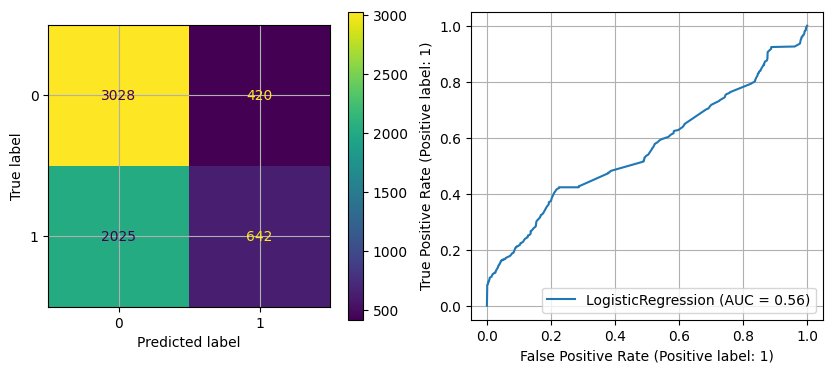

In [14]:
modelPerf(modelFit,trainX, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5943379 0.9254640 0.7238290      3448
           1  0.6554960 0.1833521 0.2865514      2667

    accuracy                      0.6017989      6115
   m

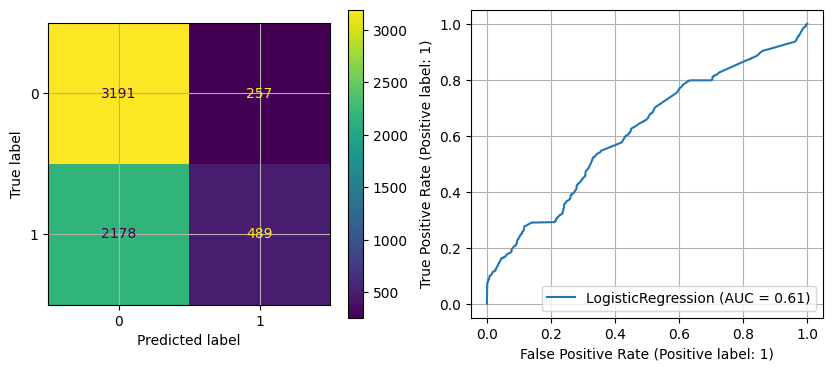

In [15]:
modelPerf(daySquareModel,trainX_quad,trainy)

In [16]:
df1=pd.DataFrame({'yDay':trainX['yDay'],'output':trainy})
df1['dayBin'] = pd.cut(df1.yDay, list(range(1,366,5)),right=False)
df2 = df1.groupby('dayBin').agg({'output':'mean'}).reset_index()
df2['leftPt'] = df2['dayBin'].apply(lambda x: x.left)

sqc1, sqc2 = daySquareModel.coef_[0]
sq_b = daySquareModel.intercept_[0]

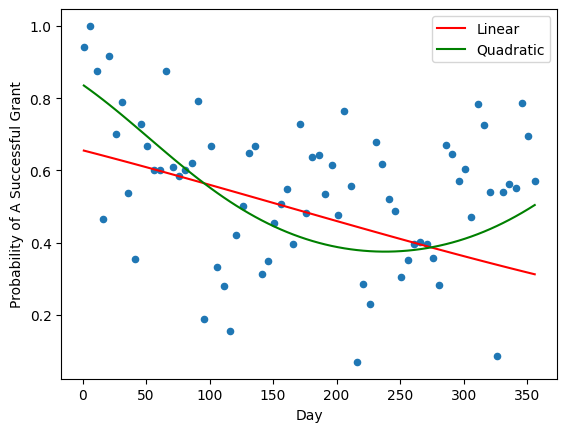

In [17]:
dx = np.linspace(1,356,72)
dy = 1/(1+np.exp(-(lin_b+lin_a*dx)))
dz = 1/(1+np.exp(-(sq_b +sqc1*dx +sqc2*dx*dx)))

ax1 = df2.plot.scatter(x = 'leftPt', y = 'output',grid = False, xlabel = 'Day', ylabel = 'Probability of A Successful Grant')
ax1.plot(dx,dy, c='red', label = 'Linear')
ax1.plot(dx,dz, c='green', label = 'Quadratic')
_ = ax1.legend()

### 2.2 Reduced set and full set

In [18]:
trainX = trainX0[reducedSet+['yDay2']]
validX = validX0[reducedSet+['yDay2']]

In [19]:
lrReducedGS = GridSearchCV(lr, logReg_param, cv=cv, scoring = 'roc_auc', n_jobs = -1)
lrReducedGS.fit(trainX, trainy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Lib

GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=3, test_size=0.25, train_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'penalty': ['l2', None],
                          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                     'sag']},
                         {'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'penalty': ['l1', 'l2', None], 'solver': ['saga']}],
             scoring='roc_auc')

In [20]:
lr_reduced = lrReducedGS.best_estimator_

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9068361 0.8694896 0.8877702      3448
           1  0.8398006 0.8845144 0.8615778      2667

    accuracy                      0.8760425      6115
   m

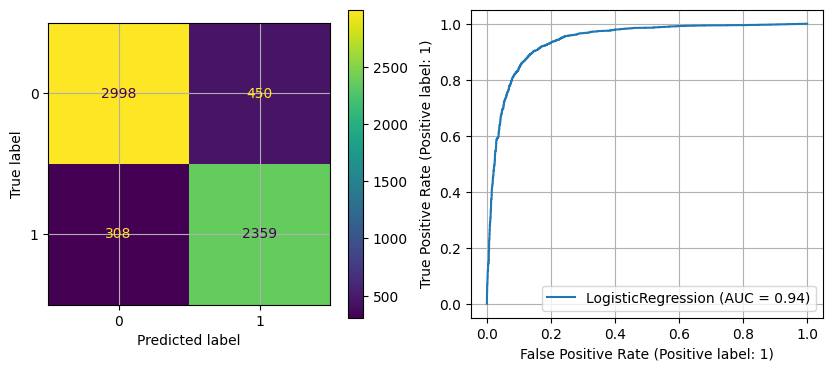

In [21]:
modelPerf(lr_reduced, trainX, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.6294174 0.6995754 0.6626445       942
           1  0.7247082 0.6575463 0.6894956      1133

    accuracy                      0.6766265      2075
   m

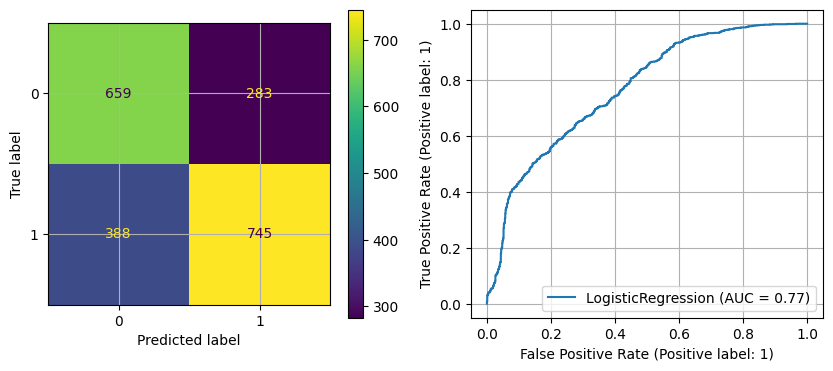

In [22]:
modelPerf(lr_reduced, validX, validy)

In [23]:
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]

In [24]:
lrFullGS = GridSearchCV(lr, logReg_param, cv=cv, scoring = 'roc_auc', n_jobs = -1)
lrFullGS.fit(trainX, trainy)
lr_full = lrFullGS.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original 

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9224319 0.8932715 0.9076175      3448
           1  0.8674352 0.9028871 0.8848062      2667

    accuracy                      0.8974652      6115
   m

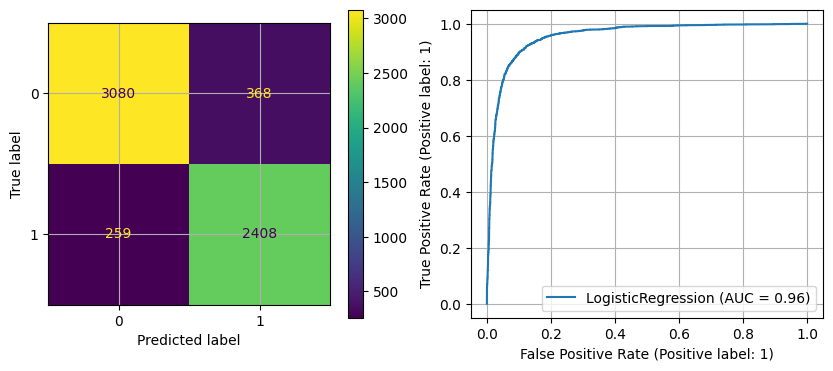

In [25]:
modelPerf(lr_full, trainX, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.6354962 0.7070064 0.6693467       942
           1  0.7312561 0.6628420 0.6953704      1133

    accuracy                      0.6828916      2075
   m

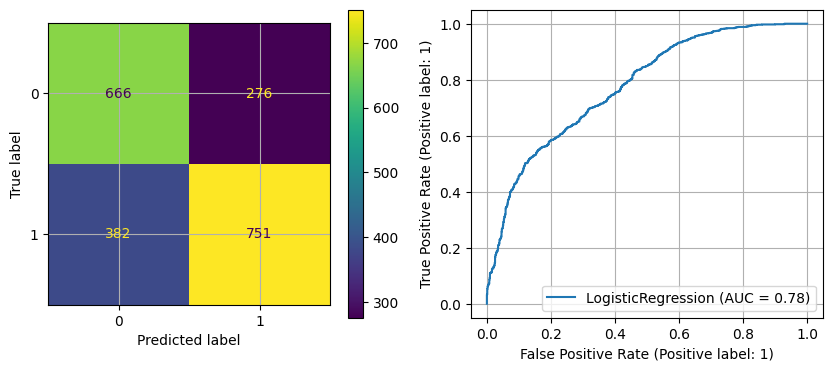

In [26]:
modelPerf(lr_full, validX, validy)

## 3. Linear Discriminant Analysis

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [28]:
trainX = trainX0[reducedSet+['yDay2']]
validX = validX0[reducedSet+['yDay2']]

In [29]:
sc = StandardScaler()
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [30]:
lda = LinearDiscriminantAnalysis()
lda_param = {'solver': ['svd','lsqr','eigen']}

In [31]:
ldaGS = GridSearchCV(lda, lda_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
ldaGS.fit(trainX_scaled, trainy)
ldaModel = ldaGS.best_estimator_

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.6313088 0.7834395 0.6991947       942
           1  0.7748344 0.6195940 0.6885728      1133

    accuracy                      0.6939759      2

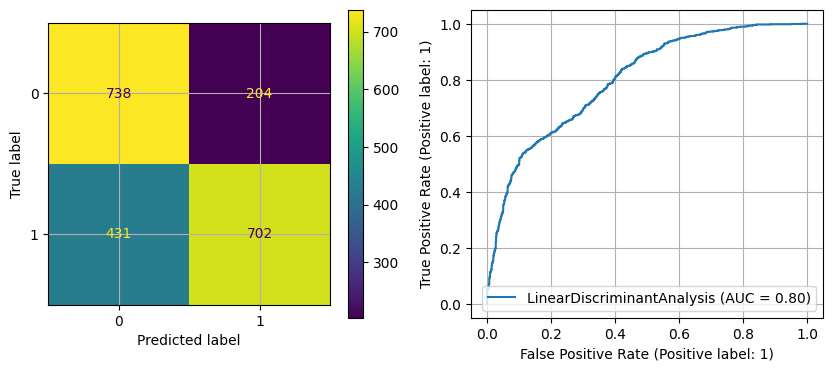

In [32]:
modelPerf(ldaModel, validX_scaled, validy)

Text(0.5, 1.0, '')

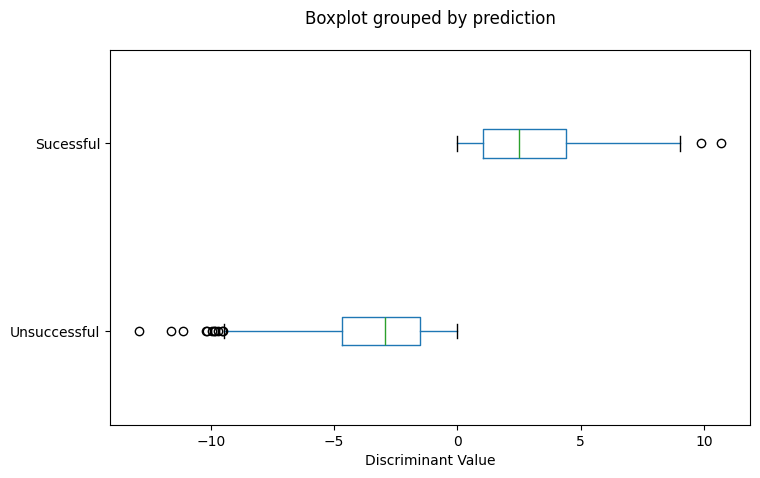

In [33]:
dfvalid = pd.DataFrame({'discriminant_value': ldaModel.decision_function(validX_scaled), 'prediction': ldaModel.predict(validX_scaled)})
fig, ax = plt.subplots(figsize = (8,5))
bplot = dfvalid.boxplot(by = 'prediction', ax = ax, vert=False, grid = False)
bplot.set_ylabel("")
bplot.set_yticks([1,2],['Unsuccessful', 'Sucessful'])
bplot.set_xlabel("Discriminant Value")
bplot.set_title("")

## 4. Partial Least Square

In [34]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

class PLSPreProc(PLSRegression):
    ''' Wrapper to allow PLSRegression to be used in the Pipeline Module '''
    def __init__(self, n_components=4, scale=False):
        super().__init__(n_components=n_components, scale=scale)

    def fit(self, X, y):
        return super().fit(X, y)

    def transform(self, X):
        return super().predict(X)

    def fit_transform(self, X, y):
        return super().fit(X,y).predict(X)

scaler = StandardScaler()
pls4 = PLSPreProc(4,False)
gnb = GaussianNB()

PLSNB = Pipeline([('scaler', StandardScaler()),('pls', pls4),('gnb',gnb)])

In [35]:
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]

In [36]:
trainy.shape

(6115,)

In [37]:
PLSNB.fit(trainX, np.array(trainy).reshape(-1,1))

Pipeline(steps=[('scaler', StandardScaler()), ('pls', PLSPreProc()),
                ('gnb', GaussianNB())])

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of Pipeline:
              precision    recall  f1-score   support

           0  0.9038288 0.8694896 0.8863267      3448
           1  0.8391708 0.8803900 0.8592864      2667

    accuracy                      0.8742437      6115
   macro avg  

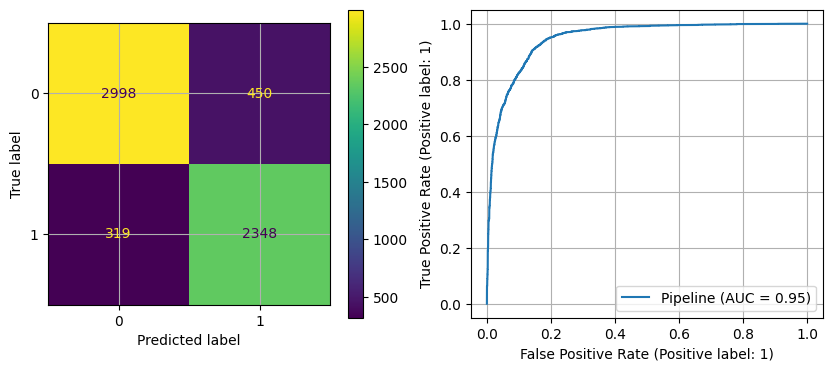

In [38]:
modelPerf(PLSNB,trainX,trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of Pipeline:
              precision    recall  f1-score   support

           0  0.6277014 0.6783439 0.6520408       942
           1  0.7133396 0.6654898 0.6885845      1133

    accuracy                      0.6713253      2075
   macro avg  

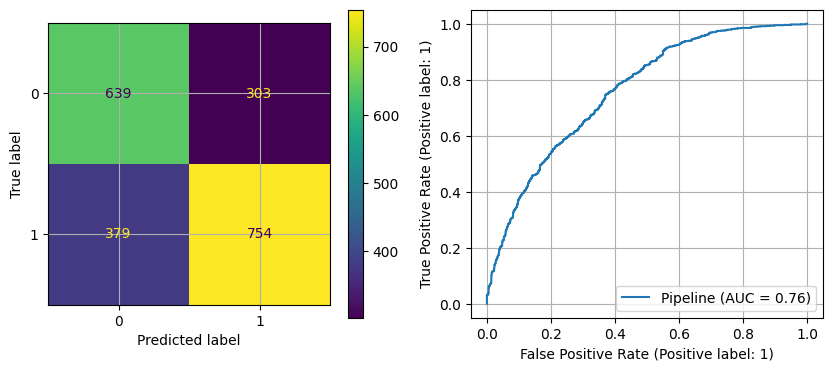

In [39]:
modelPerf(PLSNB, validX, validy)

Text(0.5, 1.0, '')

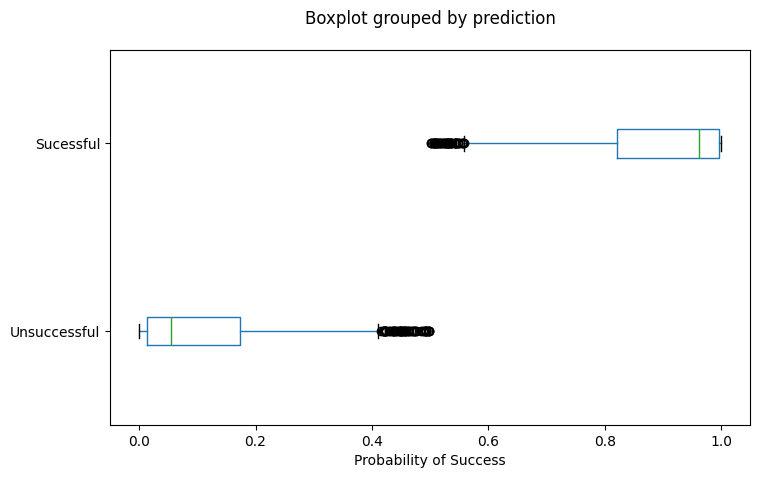

In [40]:
dfvalid = pd.DataFrame({'probability of success': PLSNB.predict_proba(validX)[:,1], 'prediction': PLSNB.predict(validX)})

fig, ax = plt.subplots(figsize = (8,5))
bplot = dfvalid.boxplot(by = 'prediction', ax = ax, vert=False, grid = False)
bplot.set_ylabel("")
bplot.set_yticks([1,2],['Unsuccessful', 'Sucessful'])
bplot.set_xlabel("Probability of Success")
bplot.set_title("")

## 5. Penalized Models

In [41]:
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

warnings.filterwarnings("ignore", message = "The max_iter was reached*")

In [42]:
sc = StandardScaler()
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [43]:
def hyperopt_train_test(params):
    lasso = LogisticRegression(**params, penalty='l1', solver = 'liblinear')
    return cross_val_score(lasso, trainX_scaled, trainy, cv=4, scoring ='roc_auc', n_jobs = -1).mean()

space4lasso = {
    'C': hp.loguniform('C',-10,4)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best_param_lasso = fmin(f, space4lasso, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best_param_lasso)

100%|█████████████████████████| 50/50 [08:22<00:00, 10.05s/trial, best loss: -0.892402013978588]
best: {'C': 0.017361581783016083}


In [44]:
lassoModel = LogisticRegression(solver = 'liblinear',penalty='l1',**best_param_lasso)
lassoModel.fit(trainX_scaled,trainy)

LogisticRegression(C=0.017361581783016083, penalty='l1', solver='liblinear')

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9272968 0.8138051 0.8668520      3448
           1  0.7921657 0.9175103 0.8502432      2667

    accuracy                      0.8590352      6115
   m

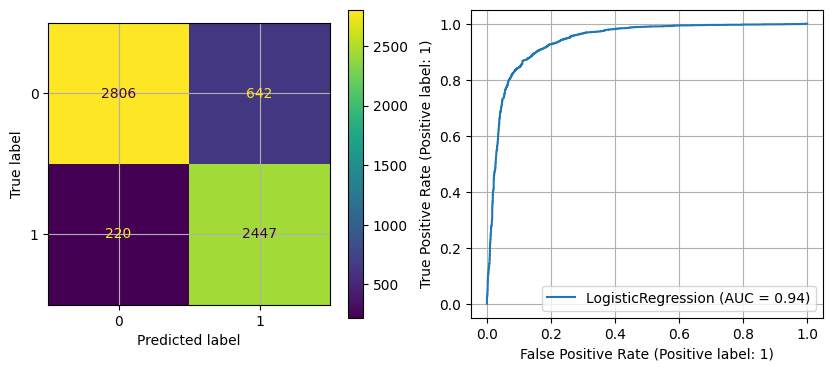

In [45]:
modelPerf(lassoModel, trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.6580125 0.7802548 0.7139388       942
           1  0.7839248 0.6628420 0.7183166      1133

    accuracy                      0.7161446      2075
   m

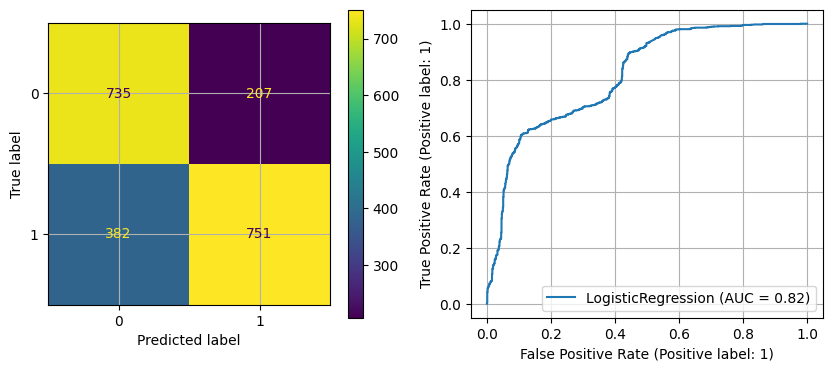

In [46]:
modelPerf(lassoModel, validX_scaled, validy)

In [47]:
nonzeroCoefIdx = np.nonzero(lassoModel.coef_)[1]
for x in nonzeroCoefIdx: 
    print(f"{(fullSet+['yDay2'])[x]:<25}: {lassoModel.coef_[0,x]}")

numSR                    : 0.05863089815173578
numSCI                   : 0.008681139670550304
CI.1970                  : -0.009301333243694048
CI.1975                  : -0.0046015244726335626
PS.1965                  : -0.0019443042328161008
Success.CI               : 0.6503209970686988
Unsuccess.CI             : -0.7359444030671363
CI.Dept1258              : -0.028597702536979578
CI.Dept2728              : -0.004238753016866233
CI.Dept2763              : -0.007180461221521693
CI.Dept2848              : -0.00625507718975159
CI.Dept3028              : 0.001929065731044239
CI.Dept3508              : -0.016894637592467315
CI.Dept4388              : 0.004699833711397773
PS.Dept1038              : -0.023928828004451178
PS.Dept2878              : 0.014740723152622294
PS.Dept2893              : 0.01268424868245303
PS.Dept3028              : 0.009218633601001698
CI.Faculty13             : 0.03551709335898101
CI.Faculty25             : -0.019782542761037452
Astar.PS                 : 0.025963

In [48]:
def hyperopt_train_test(params):
    enet = LogisticRegression(**params, max_iter=1000, penalty='elasticnet',solver='saga')
    return cross_val_score(enet, trainX_scaled, trainy, cv=4, scoring ='roc_auc').mean()

space4enet = {
    #'solver': hp.choice('solver',['saga']),
    #'penalty': hp.choice('penalty',['elasticnet']),
    #'max_iter': hp.choice('max_iter',[1000]),
    'l1_ratio': hp.uniform('l1_ratio',0,1),
    'C': hp.loguniform('C',-10,4)
}

def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4enet, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best)

100%|███████████████████████| 50/50 [1:17:45<00:00, 93.32s/trial, best loss: -0.889063814098469]
best: {'C': 0.021873662329960075, 'l1_ratio': 0.9721608523796954}


In [49]:
bestParams = best
enetModel = LogisticRegression(**bestParams,max_iter=1000, penalty='elasticnet',solver='saga')
enetModel.fit(trainX_scaled, trainy)

LogisticRegression(C=0.021873662329960075, l1_ratio=0.9721608523796954,
                   max_iter=1000, penalty='elasticnet', solver='saga')

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9249519 0.8364269 0.8784648      3448
           1  0.8118118 0.9122610 0.8591102      2667

    accuracy                      0.8695012      6115
   m

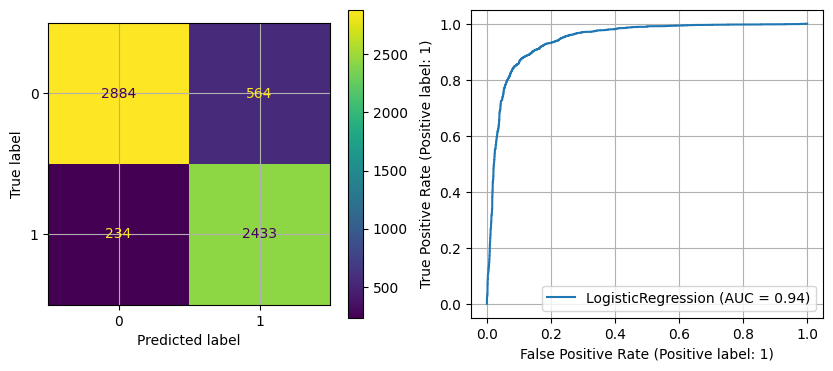

In [50]:
modelPerf(enetModel, trainX_scaled, trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.6561955 0.7983015 0.7203065       942
           1  0.7954790 0.6522507 0.7167798      1133

    accuracy                      0.7185542      2075
   m

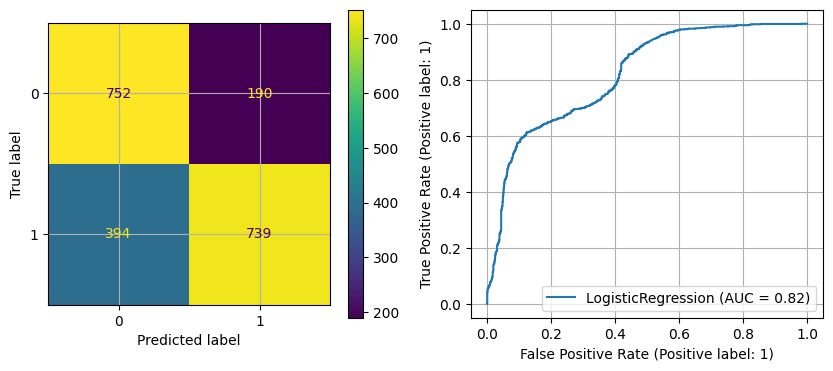

In [51]:
modelPerf(enetModel, validX_scaled, validy)

In [52]:
nonzeroCoefIdx = np.nonzero(enetModel.coef_)[1]
for x in nonzeroCoefIdx: 
    print(f"{(fullSet+['yDay2'])[x]:<25}: {enetModel.coef_[0,x]}")

numHV                    : 0.002053795185401884
numSR                    : 0.07163582926098529
numSCI                   : 0.017262535468851065
CI.1970                  : -0.030193796818842836
CI.1975                  : -0.015627919496463524
PS.1965                  : -0.015273461435254716
PS.1975                  : 0.008021993465968333
Success.CI               : 0.7184961291985029
Unsuccess.CI             : -0.797281955733707
CI.Dept1258              : -0.04692596466089026
CI.Dept2518              : -0.007590608535449185
CI.Dept2728              : -0.02167790045320992
CI.Dept2763              : -0.017414631627664216
CI.Dept2778              : 0.0040265760788736745
CI.Dept2848              : -0.01331601352774726
CI.Dept3028              : 0.008527824120430563
CI.Dept3508              : -0.02690800010610668
CI.Dept4388              : 0.0231063559505032
DR.Dept2163              : 0.004488488038744278
PS.Dept1038              : -0.03742793429429095
PS.Dept2563              : -0.00862867873

## 6. Nearest Shrunken Centroids

In [53]:
from sklearn.neighbors import NearestCentroid

In [54]:
sc = StandardScaler()
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [55]:
from sklearn.utils.extmath import softmax
from sklearn.metrics.pairwise import pairwise_distances
class NSC(NearestCentroid):
    ''' Wrapper to allow Nearest Centroid to have predict_proba and decision_function '''
    def __init__(self, metric ='euclidean', shrink_threshold=None):
        super().__init__(metric=metric,shrink_threshold=shrink_threshold)

    def predict_proba(self, X):
        distances = pairwise_distances(X, self.centroids_, metric=self.metric)
        probs = softmax(-distances)
        return probs
    
    def decision_function(self, X):
        distances = pairwise_distances(X, self.centroids_, metric=self.metric)
        probs = softmax(-distances)
        return probs[:,1]

In [56]:
nsc= NSC()
nsc_param = {'shrink_threshold': list(np.linspace(0,1,100))[1:]}

In [57]:
nscGS = GridSearchCV(nsc, nsc_param, cv=cv, scoring = 'accuracy', n_jobs = -1)
nscGS.fit(trainX_scaled, trainy)
nscModel = nscGS.best_estimator_

In [58]:
nscModel

NSC(shrink_threshold=0.3535353535353536)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of NSC:
              precision    recall  f1-score   support

           0  0.8280909 0.7711717 0.7986184      3448
           1  0.7283058 0.7930259 0.7592892      2667

    accuracy                      0.7807032      6115
   macro avg  0.778

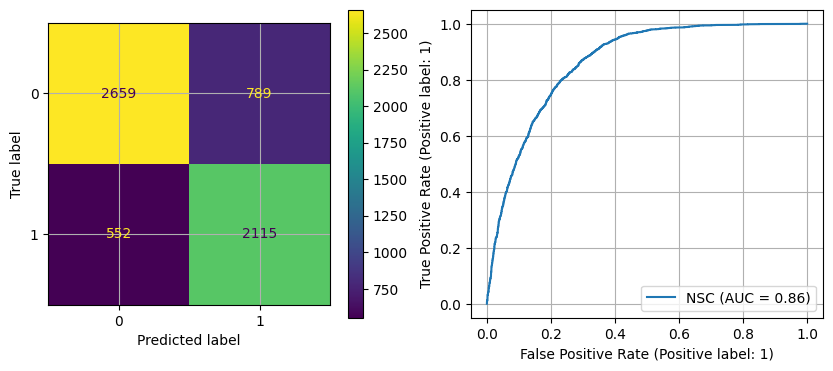

In [59]:
modelPerf(nscModel,trainX_scaled,trainy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of NSC:
              precision    recall  f1-score   support

           0  0.6116152 0.7154989 0.6594912       942
           1  0.7245632 0.6222418 0.6695157      1133

    accuracy                      0.6645783      2075
   macro avg  0.668

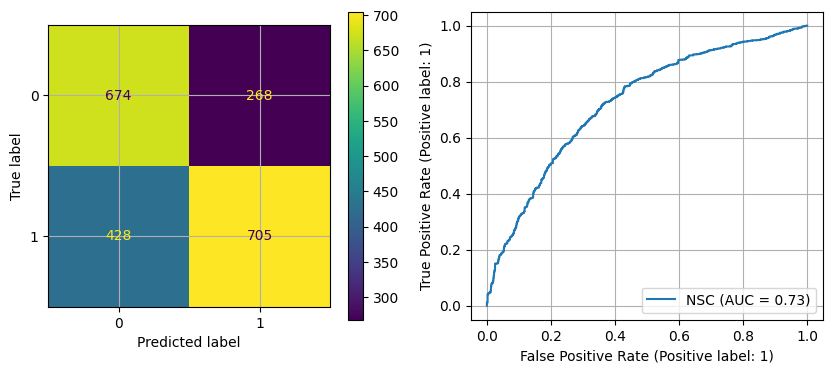

In [60]:
modelPerf(nscModel,validX_scaled,validy)